In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import time
import random
import scipy.stats as stats


In [5]:

def plotHistogram(data, bins='auto'):
    plt.figure(figsize=(15, 10))
    
    # Plotting the histogram of the input data
    plt.hist(data, bins=bins, color='skyblue', edgecolor='black', density=True, label='Data Histogram')
    
    # Generate and plot the selected distribution
    x_values = np.linspace(min(data), max(data), 1000)

    mean = np.mean(data)
    std = np.std(data)
    
    # Calculate the normal PDF
    normal_pdf = norm.pdf(x_values, mean, std)
    plt.plot(x_values, normal_pdf, label=f'Normal Distribution (mean={mean}, std={std})', color='red')

    # Adding labels and title
    plt.xlabel('Values')
    plt.ylabel('Probability')
    plt.legend()

    # Display the plot
    plt.show()



def massbinImageComparisonGPT(massbin_of_interest, data, clipped_data, clipped_sampled_data, colormap='cubehelix'):
    # Set the base colormap
    base_cmap = plt.get_cmap(colormap)

    # Create a new colormap with red for zero values
    new_cmap = mcolors.ListedColormap(base_cmap(np.linspace(0, 1, 256)))  # Create a new colormap
    new_cmap.set_under('red')  # Set color for values below the minimum (0 in this case)
    
    # Reshape the data to 500x100 for visualization
    data_matrix = data[:, massbin_of_interest].reshape((500, 100))
    clipped_data_matrix = clipped_data[:, massbin_of_interest].reshape((500, 100))
    clipped_sampled_data_matrix = clipped_sampled_data[:, massbin_of_interest].reshape((500, 100))
    
    # Create a figure with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    
    # Calculate the global min/max across all matrices for consistent color scaling
    min_val = min(np.min(data_matrix), np.min(clipped_data_matrix), np.min(clipped_sampled_data_matrix))
    max_val = max(np.max(data_matrix), np.max(clipped_data_matrix), np.max(clipped_sampled_data_matrix))
    
    # Set values less than or equal to zero to a specific number for coloring
    data_matrix[data_matrix <= 0] = np.nan  # Use NaN for zeros (or a small value if you want to keep them)
    clipped_data_matrix[clipped_data_matrix <= 0] = np.nan
    clipped_sampled_data_matrix[clipped_sampled_data_matrix <= 0] = np.nan

    # Plot each matrix with the same color scale (vmin and vmax)
    for ax, matrix, cmap, title in zip(axes, 
                                       [data_matrix, clipped_data_matrix, clipped_sampled_data_matrix], 
                                       [new_cmap] * 3, 
                                       ['Original Data', 'Clipped Data', 'Clipped & Sampled Data']):
        # Use global min and max for consistent brightness/color scaling
        cax = ax.imshow(matrix, aspect='equal', cmap=cmap, vmin=min_val, vmax=max_val, interpolation=None)
        
        # Set zero values to be red
        ax.imshow(np.ma.masked_where(matrix != 0, matrix), cmap='Reds', alpha=0.5, vmin=min_val, vmax=max_val)
        
        ax.set_title(f'{title}', fontsize=14)
        fig.colorbar(cax, ax=ax)
    
    # Add an overall title and display the plot
    fig.suptitle(f'Side by Side Comparison of Original, Clipped, and C+Sampled Data for Massbin {massbin_of_interest}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the suptitle
    plt.show()

        
def zeroCalculator(data, massbin):
    # Testing how many values are non-zero. Quite a lot. But not all. 
    r = data[:,massbin]
    
    non_zero_indices = len(np.argwhere(r != 0))   
    print(f'So, {100*non_zero_indices/len(r)}% are non-zero indices\n This means that {round(len(r)*(1-non_zero_indices/len(r)))} indices of {len(r)} are zero')
        

def general_error_relative(X_original, X_reconstructed, norm='fro'):
    """
    Compute the relative error between the original matrix X_original and the reconstructed matrix X_reconstructed
    X_original: the original matrix
    X_reconstructed: reconstructed/estimated matrix we want to compare to X_original
    """
    error = np.linalg.norm(X_original - X_reconstructed, ord=norm)
    relative_error = error / np.linalg.norm(X_original, ord=norm)
    return relative_error



In [6]:
# now clip to remove all the low-intensity values
def clip_matrix(M, threshold=0.5):
    """
    Clips the values in matrix M, setting any value below the given threshold to 0.
    
    Args:
    - M (numpy array): The input matrix (values between 0 and 1).
    - threshold (float): The clipping threshold (default 0.5).
    
    Returns:
    - M_clipped (numpy array): A new matrix with values below the threshold set to 0.
    """
    # Ensure the input matrix is a numpy array
    M = np.array(M)
    
    # Clip values below the threshold by setting them to 0
    M_clipped = np.where(M < threshold, 0, M)
    
    return M_clipped




def probabilityMatrix(n_rows, n_cols, percentage):
    one_matrix = np.ones((n_rows, n_cols), dtype=int)
    num_cells = n_rows * n_cols
    num_zeros = int(percentage * num_cells)
    
    # Flatten the matrix to choose random indices
    flat_indices = np.random.choice(num_cells, num_zeros, replace=False)
    
    # Set these chosen indices to 0
    one_matrix.flat[flat_indices] = 0
    
    return one_matrix

def randomDiscard(M, ratio_keep):
    P = probabilityMatrix(M.shape[0], M.shape[1], ratio_keep)
    return np.multiply(M, P)


# now clip to remove all the low-intensity values
def clip_matrix(M, threshold=0.5):
    """
    Clips the values in matrix M, setting any value below the given threshold to 0.
    
    Args:
    - M (numpy array): The input matrix (values between 0 and 1).
    - threshold (float): The clipping threshold (default 0.5).
    
    Returns:
    - M_clipped (numpy array): A new matrix with values below the threshold set to 0.
    """
    # Ensure the input matrix is a numpy array
    M = np.array(M)
    
    # Clip values below the threshold by setting them to 0
    M_clipped = np.where(M < threshold, 0, M)
    
    return M_clipped



def generate_matrix_with_rank(m, n, r):
    assert r <= min(m, n), "Rank r must be less than or equal to the smaller of m or n."
    
    # Generate two random matrices of size m x r and r x n
    A = np.random.rand(m, r)
    B = np.random.rand(r, n)
    
    # Multiply A and B to get a matrix of size m x n with rank r
    matrix = np.dot(A, B)
    
    return matrix



In [13]:

def threshold_percentage(data, percentage):
    mu = np.mean(data)
    sigma = np.std(data)
    return mu + sigma * stats.norm.ppf(1-percentage)




In [36]:

def partlyDiscardedClipping(data_matrix, uniform_ratio_keep, threshold=None, threshold_ratio_keep=0.6):
    # Create a figure and axis for the original matrix
    fig, ax = plt.subplots(figsize=(6, 6))  # Keeping aspect ratio

    # Plot the matrix with a color scale
    cax = ax.matshow(data_matrix, cmap='viridis')

    # Add colorbar to show the scale
    fig.colorbar(cax)

    # Show the plot
    plt.show()
    
    # Randomly discard values to create an imperfect matrix
    imperfect_matrix = randomDiscard(data_matrix, 1 - uniform_ratio_keep)

    # Replace zeros in the imperfect matrix with NaN
    imperfect_matrix_with_nan = np.where(imperfect_matrix == 0, np.nan, imperfect_matrix)

    imperfect_matrix_w_nan_w_original_zeroes = np.where(data_matrix==0,0, imperfect_matrix_with_nan)
    
    # Create a figure and axis for the imperfect matrix
    fig, ax = plt.subplots(figsize=(6, 6))  # Keeping aspect ratio

    # Plot the imperfect matrix with NaN values
    cax = ax.matshow(imperfect_matrix_w_nan_w_original_zeroes, cmap='viridis')

    # Add colorbar to show the scale
    fig.colorbar(cax)

    # Show the plot
    plt.show()

    if threshold is None:
        threshold = threshold_percentage(data_matrix, threshold_ratio_keep)

    # Clip the imperfect matrix
    clipped_imperfect_matrix = clip_matrix(imperfect_matrix, threshold)

    # Replace zeros in the clipped matrix with NaN
    clipped_imperfect_matrix_with_nan = np.where(clipped_imperfect_matrix == 0, np.nan, clipped_imperfect_matrix)
    
    clipped_imperfect_matrix_with_nan_w_original_zeroes = np.where(data_matrix==0,0, clipped_imperfect_matrix_with_nan)
    
    # Create a figure and axis for the clipped matrix
    fig, ax = plt.subplots(figsize=(6, 6))  # Keeping aspect ratio

    # Plot the clipped matrix with NaN values
    cax = ax.matshow(clipped_imperfect_matrix_with_nan_w_original_zeroes, cmap='viridis')

    # Add colorbar to show the scale
    fig.colorbar(cax)

    # Show the plot
    plt.show()

    return clipped_imperfect_matrix


In [40]:

def partlyDiscardedClipping(data_matrix, uniform_ratio_keep, threshold=None, threshold_ratio_keep=0.6):
    # Create a figure and axis for the original matrix
    fig, ax = plt.subplots(figsize=(6, 6))  # Keeping aspect ratio

    # Plot the matrix with a color scale
    cax = ax.matshow(data_matrix, cmap='viridis')

    # Add colorbar to show the scale
    fig.colorbar(cax)

    # Show the plot
    plt.show()
    
    # Randomly discard values to create an imperfect matrix
    imperfect_matrix = randomDiscard(data_matrix, 1 - uniform_ratio_keep)

    # Replace zeros in the imperfect matrix with NaN
    imperfect_matrix_with_nan = np.where(imperfect_matrix == 0, np.nan, imperfect_matrix)

    
    # Create a figure and axis for the imperfect matrix
    fig, ax = plt.subplots(figsize=(6, 6))  # Keeping aspect ratio

    # Plot the imperfect matrix with NaN values
    cax = ax.matshow(imperfect_matrix_with_nan, cmap='viridis')

    # Add colorbar to show the scale
    fig.colorbar(cax)

    # Show the plot
    plt.show()

    if threshold is None:
        threshold = threshold_percentage(data_matrix, threshold_ratio_keep)

    # Clip the imperfect matrix
    clipped_imperfect_matrix = clip_matrix(imperfect_matrix, threshold)

    # Replace zeros in the clipped matrix with NaN
    clipped_imperfect_matrix_with_nan = np.where(clipped_imperfect_matrix == 0, np.nan, clipped_imperfect_matrix)
    
    
    # Create a figure and axis for the clipped matrix
    fig, ax = plt.subplots(figsize=(6, 6))  # Keeping aspect ratio

    # Plot the clipped matrix with NaN values
    cax = ax.matshow(clipped_imperfect_matrix_with_nan, cmap='viridis')

    # Add colorbar to show the scale
    fig.colorbar(cax)

    # Show the plot
    plt.show()

    return clipped_imperfect_matrix


In [41]:
l = []
for i in range(20):
    l.append(i)
    
print(l)

print(threshold_percentage(l, 0.9))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
2.110213176029271


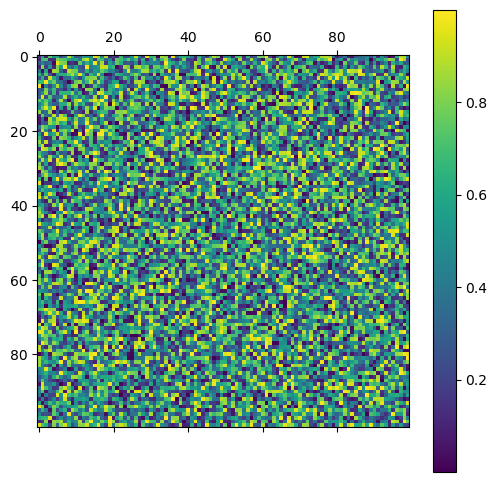

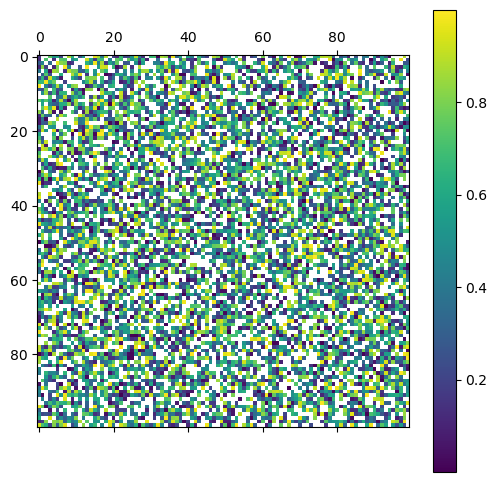

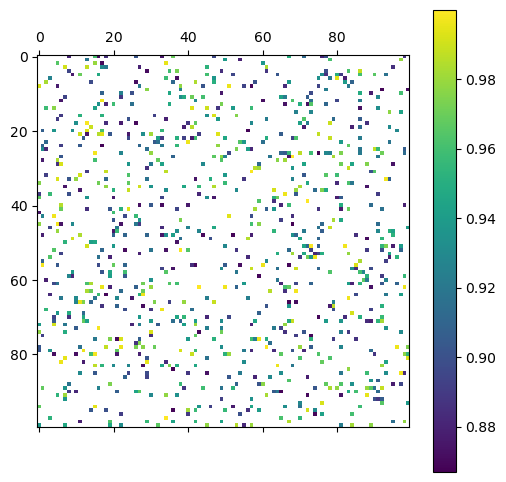

In [42]:

M = generate_matrix_with_rank(100,100,99)
matrix = np.random.rand(100, 100)



N = partlyDiscardedClipping(matrix, uniform_ratio_keep=0.7, threshold_ratio_keep=0.1)

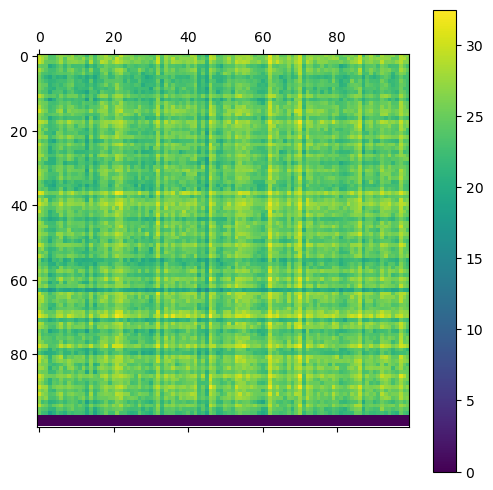

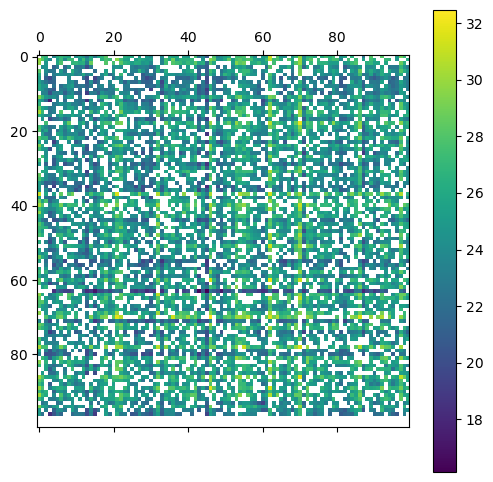

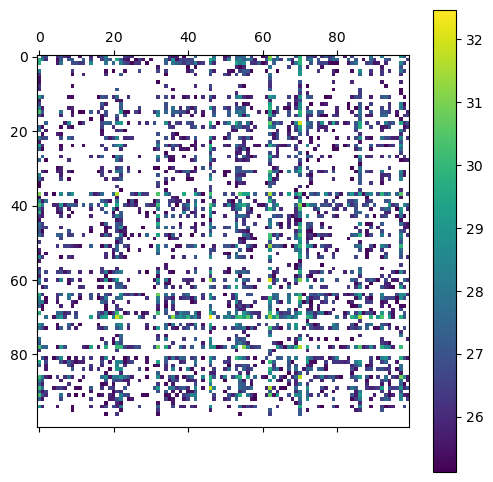

In [43]:
M[-3:,:] = 0
N = partlyDiscardedClipping(M, uniform_ratio_keep=0.7, threshold_ratio_keep=0.4)


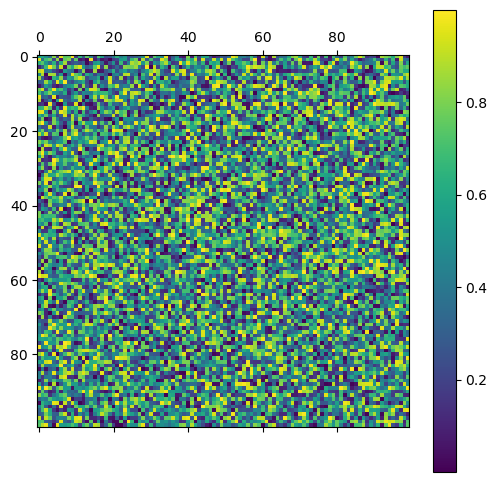

In [8]:




# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 6))  # Keeping aspect ratio

# Plot the matrix with a color scale
cax = ax.matshow(matrix, cmap='viridis')

# Add colorbar to show the scale
fig.colorbar(cax)

# Show the plot
plt.show()